In [1]:
from processor.processor import Processor as processor
from database.adatabase import ADatabase
from xgboost import XGBRegressor
from statistics import mean
import math
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from tqdm import tqdm
from dotenv import load_dotenv
from asset.stock import Stock
from asset.bond import Bond
from asset.option import Option
import warnings
import pytz
warnings.simplefilter(action="ignore")

In [2]:
factors =  ["AMZN","GOOGL","AAPL","NVDA","TSLA","MSFT","META"]
required = ["year","quarter","ticker"]
required.extend(factors)
market = ADatabase("market")
sec = ADatabase("sec")
market = ADatabase("market")
fred = ADatabase("fred")

In [3]:
def calculate_expected_return(row, factors):
    factor_loadings = [row[factor] * row[f"{factor}_beta"] for factor in factors]
    return np.mean(factor_loadings)

In [4]:
## download factors
factor_dfs = []
market.connect()
for ticker in factors:
    try:
        ticker_prices = processor.column_date_processing(market.query("prices",{"ticker":ticker}))[["date","ticker","adjclose"]]
        ticker_prices["historical_return"] = ticker_prices["adjclose"].pct_change(5) 
        factor_dfs.append(ticker_prices)
    except Exception as e:
        print(str(e))
        continue
market.disconnect()
factor_df = pd.concat(factor_dfs).pivot_table(index="date",columns="ticker",values="historical_return").reset_index()
factor_df

ticker,date,AAPL,AMZN,GOOGL,META,MSFT,NVDA,TSLA
0,2004-06-29 00:00:00+00:00,-0.015152,0.096122,NaN,NaN,0.007423,0.040581,NaN
1,2004-06-30 00:00:00+00:00,-0.034421,0.070655,NaN,NaN,0.009187,0.008374,NaN
2,2004-07-01 00:00:00+00:00,-0.026522,0.030184,NaN,NaN,0.008454,-0.029324,NaN
3,2004-07-02 00:00:00+00:00,-0.077745,0.015251,NaN,NaN,0.000000,-0.048889,NaN
4,2004-07-06 00:00:00+00:00,-0.047399,-0.040270,NaN,NaN,-0.009194,-0.097112,NaN
...,...,...,...,...,...,...,...,...
5025,2024-06-14 00:00:00+00:00,0.079232,-0.003473,0.014514,0.023734,0.044167,0.091017,0.002986
5026,2024-06-17 00:00:00+00:00,0.121945,-0.016038,0.012742,0.009018,0.047912,0.075547,0.078543
5027,2024-06-18 00:00:00+00:00,0.034468,-0.023607,-0.008663,-0.014749,0.031571,0.121330,0.083206
5028,2024-06-20 00:00:00+00:00,-0.015910,-0.004227,-0.008381,-0.013054,0.010520,0.044569,0.024141


In [5]:
sp500 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies",attrs={"id":"constituents"})[0].rename(columns={"Symbol":"ticker"})

In [6]:
fred.connect()
market_yield = fred.retrieve("market_yield")
market_yield = market_yield.rename(columns={"value":"rf"})
market_yield["rf"] = market_yield["rf"].replace(".",0)
market_yield["rf"] = [float(x)/100 for x in market_yield["rf"]]
market_yield = processor.column_date_processing(market_yield)
spy = fred.retrieve("sp500")
spy = spy.rename(columns={"value":"spy"})
spy["spy"] = spy["spy"].replace(".",np.nan)
spy.dropna(inplace=True)
spy["spy"] = [float(x) for x in spy["spy"]]
spy = processor.column_date_processing(spy)
fred.disconnect()

In [7]:
simulation = []
market.connect()
for ticker in tqdm(sp500["ticker"]):
    try:
        ticker_prices = processor.column_date_processing(market.query("prices",{"ticker":ticker}))
        ticker_prices = ticker_prices.merge(spy[["date","spy"]],on="date",how="left")
        ticker_prices = ticker_prices.merge(market_yield[["date","rf"]],on="date",how="left")
        ticker_prices["ticker"] = ticker
        ticker_prices.sort_values("date",inplace=True)
        ticker_prices = processor.merge(ticker_prices,factor_df.copy(),on="date")
        ticker_prices["historical_return"] = ticker_prices["adjclose"].pct_change(5)
        ticker_prices["average_return"] = ticker_prices["adjclose"].pct_change(5).rolling(100).mean()
        ticker_prices["coev"] = ticker_prices["adjclose"].pct_change(5).rolling(100).std() / ticker_prices["adjclose"].pct_change(5).rolling(100).mean()
        ticker_prices["sigma"] = ticker_prices["adjclose"].pct_change(262).rolling(262).std()
        for factor in factors:
            ticker_prices[f"{factor}_covariance"] = ticker_prices["historical_return"].rolling(100).cov(ticker_prices[factor])
            ticker_prices[f"{factor}_beta"] = ticker_prices[f"{factor}_covariance"] / ticker_prices[factor].rolling(100).var()
            ticker_prices[f"{factor}_loading"] = ticker_prices[factor] * ticker_prices[f"{factor}_beta"]
        ticker_prices["expected_return"] = ticker_prices.apply(lambda row: calculate_expected_return(row, factors), axis=1)
        ticker_prices["benchmark_historical_return"] = ticker_prices["spy"].pct_change(5)
        ticker_prices["covar"] = ticker_prices["historical_return"].rolling(100).cov(ticker_prices["benchmark_historical_return"].rolling(100).mean())
        ticker_prices["var"] = ticker_prices["benchmark_historical_return"].rolling(100).var()
        ticker_prices["beta"] = ticker_prices["covar"] / ticker_prices["var"]
        ticker_prices["excess_return"] = ticker_prices["rf"] + ticker_prices["beta"] * (ticker_prices["expected_return"] - ticker_prices["rf"])
        simulation.append(ticker_prices)
    except Exception as e:
        print(ticker,str(e))
        continue

 12%|██████████████████▎                                                                                                                                  | 62/503 [00:16<02:02,  3.59it/s]

BRK.B 'date'


 16%|███████████████████████                                                                                                                              | 78/503 [00:20<01:51,  3.81it/s]

BF.B 'date'


 27%|███████████████████████████████████████▍                                                                                                            | 134/503 [00:34<01:34,  3.91it/s]

CRWD 'date'


 44%|█████████████████████████████████████████████████████████████████▌                                                                                  | 223/503 [00:57<01:14,  3.76it/s]

GDDY 'date'


 56%|██████████████████████████████████████████████████████████████████████████████████▍                                                                 | 280/503 [01:11<00:57,  3.91it/s]

KKR 'date'


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 503/503 [02:10<00:00,  3.86it/s]

ZBH 'date'
ZTS 'date'


In [8]:
sim = pd.concat(simulation).merge(sp500[["ticker","GICS Sector"]],on="ticker",how="left").dropna()
sim = sim[sim["date"]>datetime(2024,1,1).astimezone(pytz.utc)]

In [9]:
sim = sim[["date","week","weekday","ticker","adjclose","GICS Sector","expected_return","historical_return","average_return","coev","excess_return","rf","sigma"]]
sim

,date,week,weekday,ticker,adjclose,GICS Sector,expected_return,historical_return,average_return,coev,excess_return,rf,sigma
4916,2024-01-02 00:00:00+00:00,1,1,MMM,90.701148,Industrials,-0.006946,0.034515,0.004074,9.023955,0.041756,0.0395,0.065382
4917,2024-01-03 00:00:00+00:00,1,2,MMM,88.878880,Industrials,-0.010233,-0.002960,0.004352,8.411942,0.041292,0.0391,0.066111
4918,2024-01-04 00:00:00+00:00,1,3,MMM,89.192211,Industrials,-0.013517,-0.005242,0.004390,8.335246,0.042176,0.0399,0.066901
4919,2024-01-05 00:00:00+00:00,1,4,MMM,89.538525,Industrials,-0.012217,-0.010028,0.004462,8.193257,0.042621,0.0405,0.067662
4920,2024-01-08 00:00:00+00:00,2,0,MMM,89.761155,Industrials,-0.003295,-0.004208,0.004706,7.738075,0.041725,0.0401,0.068449
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2262529,2024-06-13 00:00:00+00:00,24,3,ZBRA,308.910000,Information Technology,0.005617,0.004618,0.011401,4.088778,0.040603,0.0424,0.125067
2262530,2024-06-14 00:00:00+00:00,24,4,ZBRA,301.370000,Information Technology,0.004965,0.001795,0.010903,4.260192,0.039968,0.0420,0.125559
2262531,2024-06-17 00:00:00+00:00,25,0,ZBRA,302.400000,Information Technology,0.008127,-0.000661,0.010269,4.495596,0.040623,0.0428,0.126067
2262532,2024-06-18 00:00:00+00:00,25,1,ZBRA,295.250000,Information Technology,0.006675,-0.020340,0.009769,4.731632,0.039805,0.0422,0.126161


In [10]:
start = sim["date"].min()
end = sim["date"].max()
date = start
portfolio = {"date":date,"cash":100000,"positions":[{"stock":{"ticker":"","adjclose":0,"quantity":0},"bond":{},"option":{}} for i in range(11)]}
states = []
while date < end:
    today = sim[sim["date"]==date].copy()
    if today.index.size > 0:
        try:
            portfolio = portfolio.copy()
            week = today["week"].mean()
            day = today["weekday"].mean()
            cash = portfolio["cash"]
            portfolio["date"] = date
            positions = portfolio["positions"].copy()
            for i in range(11):
                notional = cash / 11
                position = positions[i].copy()
                sector = list(sp500["GICS Sector"].unique())[i]
                stock = position["stock"].copy()
                bond = position["bond"].copy()
                option = position["option"].copy()
                ticker = stock["ticker"]
                if ticker != "":
                    row = today[today["ticker"]==ticker].iloc[0]
                    stock = Stock.update(row,stock)
                    position["stock"] = stock
                    bond = Bond.update(row,bond)
                    position["bond"] = bond
                    option = Option.update(row,option)
                    position["option"] = option
                    positions[i] = position
            portfolio["positions"] = positions.copy()
            if day == 0:
                cash = portfolio["cash"]
                positions = portfolio["positions"].copy()
                for i in range(11):
                    notional = float(cash / 11)
                    position = positions[i].copy()
                    sector = list(sp500["GICS Sector"].unique())[i]
                    stock = position["stock"].copy()
                    bond = position["bond"].copy()
                    option = position["option"].copy()
                    ticker = stock["ticker"]
                    if ticker != "":
                        row = today[today["ticker"]==ticker].iloc[0]
                        stock = Stock.sell(row,stock)
                        position["stock"] = stock
                        bond = Bond.sell(row,bond)
                        position["bond"] = bond
                        option = Option.sell(row,option)
                        position["option"] = option
                        portfolio["positions"][i] = position
                        portfolio["cash"] = portfolio["cash"] + stock["pv"] + bond["pv"] + option["pv"]
                        positions[i] = position
                portfolio["positions"] = positions.copy()
                cash = portfolio["cash"]
                positions = portfolio["positions"].copy()
                for i in range(11):
                    notional = float(cash / 11)
                    position = positions[i].copy()
                    sector = list(sp500["GICS Sector"].unique())[i]
                    stock = position["stock"].copy()
                    bond = position["bond"].copy()
                    option = position["option"].copy()
                    row = today.sort_values("average_return",ascending=True).iloc[i]
                    row["type"] = "trade"
                    row["absolute_return"] = 1
                    stock = Stock.buy(row,stock,notional * 1)
                    position["stock"] = stock
                    bond = Bond.buy(row,bond,notional * 0.0)
                    position["bond"] = bond
                    option = Option.buy(row,option,notional * 0.0)
                    position["option"] = option
                    positions[i] = position
                portfolio["positions"] = positions.copy()
                portfolio["cash"] = 0
            states.append(portfolio.copy())
            date = date + timedelta(days=1)
        except Exception as e:
            print(week,i,str(e))
            date = date + timedelta(days=1)
    else:
        date = date + timedelta(days=1)

In [11]:
for state in states:
    try:
        state["stock_pv"] = sum([state["positions"][i]["stock"]["pv"] for i in range(11)])
        state["option_pv"] = sum([state["positions"][i]["option"]["pv"] for i in range(11)])
        state["bond_pv"] = sum([state["positions"][i]["bond"]["pv"] for i in range(11)])
        state["pv"] = state["cash"] + state["stock_pv"] + state["option_pv"] + state["bond_pv"]
    except:
        continue

In [12]:
performance = pd.DataFrame(states).dropna()

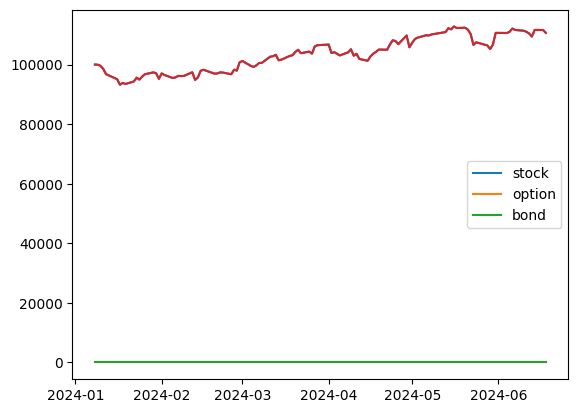

In [13]:
plt.plot(performance["date"].values,performance["stock_pv"].values)
plt.plot(performance["date"].values,performance["option_pv"].values)
plt.plot(performance["date"].values,performance["bond_pv"].values)
plt.plot(performance["date"].values,performance["pv"].values)
plt.legend(["stock","option","bond"])

In [14]:
visualization = performance.merge(spy,on="date",how="left")

In [15]:
visualization["return"] = (visualization["pv"] - visualization["pv"].iloc[0]) / visualization["pv"].iloc[0]
visualization["benchmark_return"] = (visualization["spy"] - visualization["spy"].iloc[0]) / visualization["spy"].iloc[0]

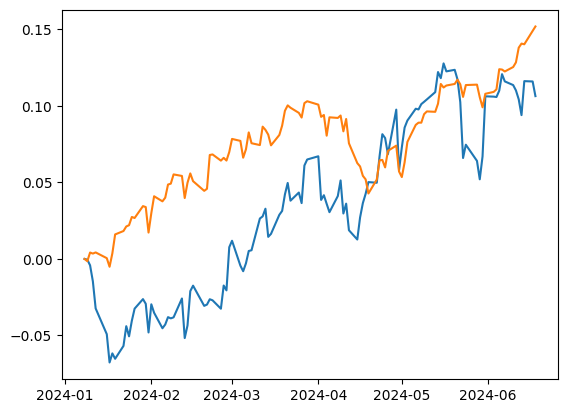

In [16]:
plt.plot(visualization["date"].values,visualization["return"])
plt.plot(visualization["date"].values,visualization["benchmark_return"])

In [17]:
states[-1]

{'date': Timestamp('2024-06-18 00:00:00+0000', tz='UTC'),
 'cash': 0,
 'positions': [{'stock': {'ticker': 'EPAM',
    'adjclose': np.float64(170.25),
    'quantity': np.float64(58.1841869477253),
    'type': 'trade',
    'expected_return': np.float64(0.0010058510005975952),
    'buy_price': np.float64(174.36),
    'buy_date': Timestamp('2024-06-17 00:00:00+0000', tz='UTC'),
    'pv': np.float64(9905.857827850232),
    'sell_date': Timestamp('2024-06-17 00:00:00+0000', tz='UTC')},
   'bond': {'adjclose': np.float64(657.6423537420742),
    'quantity': np.float64(0.0),
    'rate': np.float64(0.042800000000000005),
    'pv': np.float64(0.0)},
   'option': {'buy_date': Timestamp('2024-06-17 00:00:00+0000', tz='UTC'),
    'strike_price': np.float64(200.514),
    'premium': np.float64(24.061078296837508),
    'contract_price': np.float64(224.57507829683752),
    'quantity': np.float64(0.0),
    'notional': 0.0,
    'pv': np.float64(0.0),
    'adjclose': np.float64(170.25),
    'return': np.fl